# Evolution in progress! Change of finches beaks over 'observable' time.

Why study this? The Darwin's finches dataset we'll be using is easily one of the most exciting in science, because you can observe what many have called real-time evolution or ["evolution ocurring before our eyes"](https://www.google.com.mx/books/edition/The_Beak_of_the_Finch/NLdZAwAAQBAJ?hl=en&gbpv=1&dq=the+beak+of+the+finch&printsec=frontcover)

This data was sourced from the book ["40 Years of Evolution: Darwin's Finches on Daphne Major Island"](https://www.jstor.org/stable/j.ctt5hhncc?typeAccessWorkflow=login), whose authors, Peter and Rosemary Grant, have made publicly available.

The Grants have taken many measurements accross the years on the finches of the Galapagos. 
What's special about this place is the islands are very small, so you can monitor the entire population, and are isolated, so they do not have complicated effects from interactions with other species, including humans. 

**Follow along as we delve into this fascinating dataset, using many hand-made functions and a 'hacker' statistical approach * to explore, simulate, visualize, and ultimately study how these bird species have evolved in real time.**

* *Note: Hacker statistics is a loosely defined term that refers to a hands-on and pragmatical  approach or mindset. It emphasizes empirical distributions (i.e. ecdf), simulations, and resampling, in lieu of hypothesis testing, to work with real-world data, which is often messy and imperfect. It is best applied when assumptions about the data needed for formal statistical techniques, are not applicable. *

![Geospiza fortis & Geospiza Scandens bird species](birds.PNG "Geospiza fortis & Geospiza Scandens bird species")

First, we'll import everything we need to start analyzing.

In [2]:
# Importing of packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing the datasets
beaks_1975 = pd.read_csv('datasets/finch_beaks_1975.csv')
beaks_2012 = pd.read_csv('datasets/finch_beaks_2012.csv')


## Beak depth across the years
<br>

![Beak dimensions](beak_dimensions.jpg "Beak dimensions")

We will begin to study how the beak depth (the distance, top to bottom, of a closed beak) of only the finch species Geospiza scandens has changed over time.
To start with, let's plot all of the beak depth measurements in 1975 and 2012 in an ECDF. An Empirical Cumulative Distribution Function shows the empirical measure of a sample by graphing the cumulative probability of each data point. Although it may sound complicated, we ultimately want it to visualize the distribution of the data, and in the next cell you'll see what a great tool it is for this! 

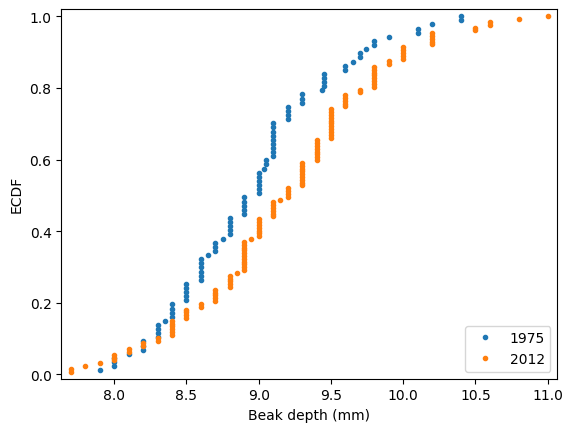

In [3]:
# Filter for only the G. Scandens species
scandens_1975 = beaks_1975[beaks_1975['species'] == 'scandens']
scandens_2012 = beaks_2012[beaks_2012['species'] == 'scandens']

# Transform relevant data (beak depth) to a 1D np array
bd_1975 = np.array(scandens_1975['Beak depth, mm'])
bd_2012 = np.array(scandens_2012['bdepth'])

# Define a function to manually create ecdfs, as it'll be used twice
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('Beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()



The y-axis goes from 0 to 1 as this is the represents the probability of finding a value equal to or less than the value in the x-axis (0 to 100% probability), but what interests us here is the spread in the x-axis, as we can clearly see that 2012 data is further to the right, **signifying a higher mean. The variance does appear larger as well.**

Incredible! In only 37 years we can visually identify a growth in beak depths for the G. Scandens species.

## Difference of means

Now, let's get the numbers on what we have observed, and **estimate the *difference* of means** between 1975 and 2012, and **report its confidence interval.**

In [4]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, len(data)))

    return bs_replicates

# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('Difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

Difference of means = 0.22622047244094645 mm
95% confidence interval = [0.05947946 0.39293678] mm


Great! Our hand-made function serves to create bootsrap distribution of sample means for both years. Calculating the percentiles corresponding to a 95% confidence interval, has allowed us to generate a very good estimate for it.

## Hypothesis testing!

We've gotten visual and numerical results corresponding to deeper beaks in the year 2012, but, isn't there still a chance that this was all coincidental? To clear any lingering doubts, we'll conduct a hypothesis test, setting our null hypothesis and alpha as:

    N0 = means for the two distributions are equal.
    alpha = 0.01

To perform this, we'll shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means. 

Let's see if we can prove this wrong and obtain verified evidence that indeed the mean beak depth has increased.

In [5]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute and print the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

print('p =', p)

p = 0.0042


Our resulting p-value is well below the already-strict alpha value. This means **there is a statistically significant difference between the means.** To illustrate how substantial this change of ~ 0.22mm in just 37 years is, in evolutionary standards, imagine that this growth rate continued as is... in just 400 years the beak depth would get to be double in size!

There are a few hypotheses as to why this is the case. One reason for this change may be a drought in 1976 and 1977 that resulted in the death of the plants that produce small seeds on the island. The larger seeds required deeper beaks to crack them, so large-beaked birds survived and then reproduced. If this is the case, it stands to reason that the length of the beak might also change over time. Importantly, if the length and depth change at the same rate, the beak has the same shape; it just gets bigger. But if the beak length and beak depth change differently, the shape of the beak changes. Let's now investigate how beak length and depth change together. **That means it's time for some scatter plots and linear regression!**

## Beak depth VS Beak length

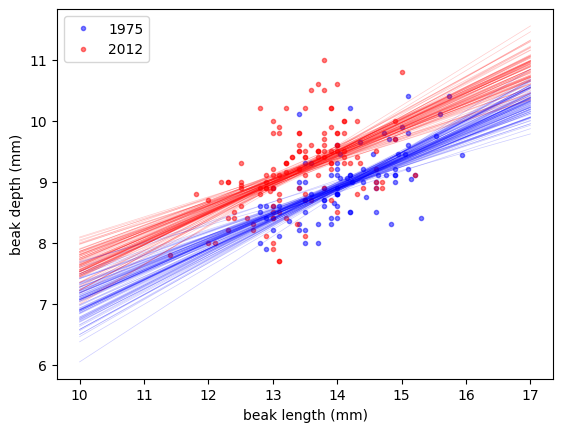

1975: slope = 0.4652051691605937 conf int = [0.34206739 0.60360794]
1975: intercept = 2.3908752365842263 conf int = [0.46954953 4.10695122]
2012: slope = 0.462630358835313 conf int = [0.33412155 0.6001343 ]
2012: intercept = 2.977247498236019 conf int = [1.13041339 4.7257957 ]


In [6]:
# Perform a linear regression for both years. Perform pairs bootstrap estimates for the regression parameters. Report 95% confidence intervals on the slope and intercept of the regression line.
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

# Transform beak length into a 1D array
bl_1975 = np.array(scandens_1975['Beak length, mm'])
bl_2012 = np.array(scandens_2012['blength'])

# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, (2.5, 97.5))
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, (2.5, 97.5))
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, (2.5, 97.5))
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, (2.5, 97.5))


# ------- Plot the linear regressions with scatterplots for both sets of data -------   
# Scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
            linestyle='None', color='red', alpha=0.5)

_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

plt.show()

# Get parameters in written format
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

Although the code in the previous cell may look daunting, all we've done is used 'hacker statistics' to fit lines that represent the relationship between those two variables; then we used boostrap resampling to plot all the lines that correspond to the 95% confidence interval of that regression line to explore it visually.

The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that **for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years.** However, if we are interested in the shape of the beak, **we want to compare the *ratio* of beak length to beak depth.** Let's make that comparison. 

## Ratio of beak length VS beak depth

In [7]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, size=10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55683567 1.60157059]
2012: mean ratio = 1.4658342276847767 conf int = [1.44398955 1.48792078]


The mean beak length-to-depth ratio decreased by about 0.1, or 7% from 1975 to 2012. It may not seem much, coming from sample data, but if we look at the values for the 99% confidence intervals we can see that they are not even overlapping. We can conclude that the beak shape has indeed changed.

## Estimating heritability

We mentioned the drought as a possible reason for the beaks getting deeper, but why do some birds have such large beaks to begin with? And why might there be more variance in the 2012 data? A prevailing explanation is that scandens birds are mating the other major finch species on Daphne Major, Geopsiza fortis. These hybrid birds then mate with pure scandens, in a process called introgressive hybridization, which can bring fortis characteristics into the scandens species. In order assess the viability of this explanation, we need to know how strongly parental traits are passed on to offspring. **So first, some visual exploration:**

We'll import four new files that contain mean beak depth measurements for parents and their corresponding offspring. Two are for the parents and offspring in the G. scandens species, and the other two for the G. fortis.  Then we'll plot the parents vs the offspring measurement in a scatterplot with a legend for both species, to see how strongly the attributes are being passed down in each species, separetely.


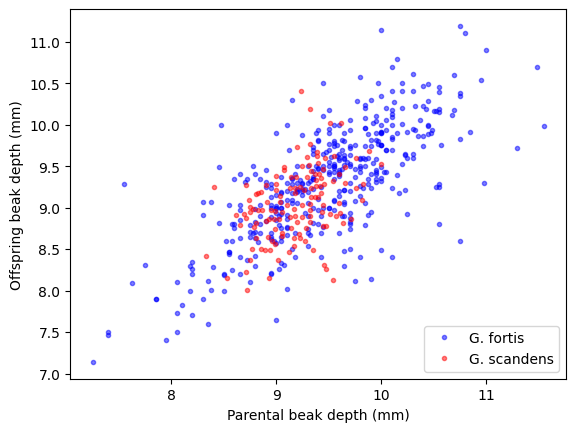

In [10]:
# Import the new data
bd_parent_scandens     = np.loadtxt('datasets/bd_parents_scandens.csv', delimiter=',')
bd_offspring_scandens  = np.loadtxt('datasets/bd_offspring_scandens.csv', delimiter=',')

bd_parent_fortis       = np.loadtxt('datasets/bd_parents_fortis.csv', delimiter=',')
bd_offspring_fortis    = np.loadtxt('datasets/bd_offspring_fortis.csv', delimiter=',')

# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
_ = plt.xlabel('Parental beak depth (mm)')
_ = plt.ylabel('Offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()

Indeed it appears as though there is a stronger correlation in G. fortis than in G. scandens. This suggests that beak depth is more strongly inherited in G. fortis. **We'll quantify this correlation next.**

One may be tempted to use a Pearson Correlation test to measure the heritability, but that is a measure of ratio of the covariance between the two sets of data. What we actually want to look at is the ratio of the covariance between parent and offspring to the *variance of the parents alone.* 

We will create two more custom functions this time!
- One to measure the heritability as we defined it above.
- And one to use boostrap resampling to calculate the confidence intervals. Before, we used a custom function to draw Boostrap pairs for the linear regression; this new function will be very similar, but it'll compute a single statistic (our heritability function) for the drawn pairs.

## Pearson Correlation and CIs

In [14]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
        
    return bs_replicates

def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens,
                                     bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis,
                                   bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: 0.5485340868685982 [0.35822357 0.73721543]
G. fortis: 0.7229051911438156 [0.64860861 0.79302878]


Now we have analytically confirmed that **G. fortis has stronger heritability than G. scandens.** This suggests that the traits of G. fortis may be strongly incorporated into G. scandens by introgressive hybridization.

## Is there actually heritability in G. scandens at all?

After getting such a strong result for the G. fortis, one may wonder if the correlation we found for G. scandens could've been just af fluke, a product of chance alone inherent in the sampling process. The only way to know for sure is to **perform a pairs permutation hypothesis test.** 

This test works by shuffling the dataset of the parents, and then calculate the heritability between the now shuffled data and the original, unmixed offspring data. This operations will be repeated 10,000 times. The idea is that if it is in fact the case that there is no heritability between the two, then a lot of our simulations will achieve a result just as large as the one we calculated for the orginal data. If it rarely happens by chance after 10,000 attempts then it is extremely unlikely that chance is the culprit here. We'll use:

    H0: There is no real heritability between parents and offspring of the G. scandens species
    alpha = 0.01

In [17]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted,
                                      bd_offspring_scandens)

# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)

p-val = 0.0


Given this is a simulation, results will vary slightly every time the cell code is run, but at the time of writing, my results were a p-value of zero! This means that none of the 10,000 permutation pairs replicates drawn had a heritability high enough to match that which was observed. **We can only conclude that it is quite definitely the case that the G. scandens species experiences heritability as well, just not as strongly as the G. fortis.** 

## Conclusions

Great work following along with me this far! What's important about this project is that we were able to use unconventional tools like bootsrap simulations of the population distribution, to estimate parameters and calculate confidence intervals when other rigid statistical formulas wouldn't hold (unable to make certain assumptions, small dataset, etc.)

We were able to conclude that indeed evolution has occured within the lifespan of a person, which is amazing and I never would've thought possible before finding this dataset; however, all the real credit goes to the Grants who uncovered all of this and made it public, and to Professor Justin Bois, whose course in Datacamp taught me all of this statistical techniques and all of the data exploration is based on work done for his course.  Many thanks to them and to you for reading this analysis.